In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### In this notebook, we use a descompose a covariance matrix with the spectral theorem and then we train a convolutional autoencoter to learn to generate fake covariance matrices. 

#### First, we need to read the data. In this case, we use the covariance matrix of systematic erros from Pantheon compilation of SN-1a 

In [3]:
syscov = np.loadtxt('https://raw.githubusercontent.com/ja-vazquez/SimpleMC/master/simplemc/data/pantheon_sys_full_long.txt',skiprows=1).reshape((1048,1048))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [4]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

3

### Visualization of the covariance matrix:

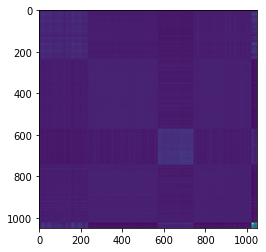

In [5]:
plt.imshow(syscov)

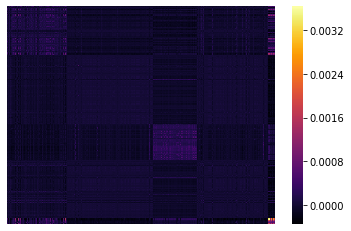

In [6]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')


In [7]:
np.min(syscov.diagonal()) #checking non-negatives in the diagonal

3.5145e-05

### Use matrix descomposition (spectral theorem) (NOT USE THIS FOR NOW)

### $\Sigma = P D P^T$

#### where P is an orthogonal matrix with the eigenvectors from $\Sigma$ and D a diagonal matrix with its eigenvalues.

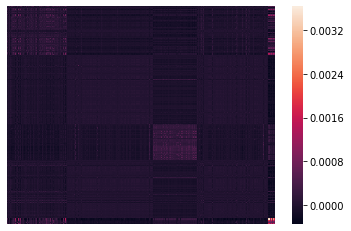

In [8]:
# eigenval, eigenvec = sp.linalg.eigh(syscov)
D, P = sp.linalg.eigh(syscov)
D = np.diag(D)
rec_cov = P @ D @ P.T
sns.heatmap(pd.DataFrame(rec_cov), annot=False, fmt='g', xticklabels=False, yticklabels=False, )

#### Checking that there are not complex values

In [9]:
count = 0

for i in range(len(P)):
    for j in range(len(P)):
        if np.iscomplex(P[i,j]):
#             print("COMPLEX")
            count+=1
#             print(i,j)
#             print(eigenvec[i,j])

print(count)

0


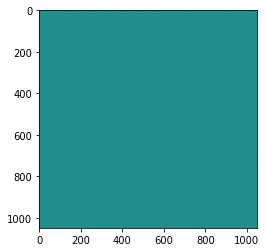

In [9]:
plt.imshow(P)

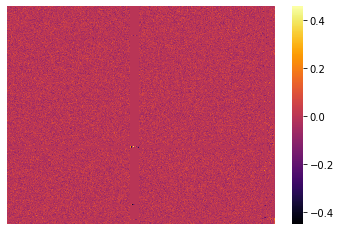

In [10]:
sns.heatmap(pd.DataFrame(P), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

### Generate a data set with matrices of eigenvectors from the original plus gaussian noise

In [ ]:
numMatrix = 500
noise_factor = 1e-5
maxval = np.max(P)
print("Max absolute value of P".format(maxval))
Pscaled = P / maxval
pset = np.zeros((numMatrix, 1048, 1048))
for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    pset[i] = Pscaled  + noise_factor * np.random.normal(loc=0.0, scale=0.01, size=P.shape) 
    fig = plt.figure(figsize=(6,6))
    sns.heatmap(pd.DataFrame(pset[i]*maxval), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', cbar=False,
            robust=False)
    fig.savefig('image/covMatrix_{}.png'.format(i), dpi=300, )
    plt.clf()

Max absolute value of P
 Generating 21 matrix 

/home/isidro/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


 Generating 256 matrix 

In [12]:
print(np.shape(pset))

(500, 1048, 1048)


(500, 1048, 1048)
(100, 1048, 1048) (400, 1048, 1048)


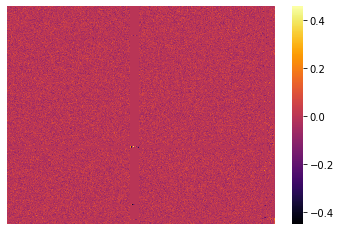

In [13]:
print(np.shape(pset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
pset_train, pset_test = np.split(pset, indx, axis=0)
print(np.shape(pset_test), np.shape(pset_train))
sns.heatmap(pd.DataFrame(pset_test[0, :, :]*maxval), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [14]:

input_cov = Input(shape=(1048, 1048, 1))

x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(input_cov)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)

encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# x = layers.Flatten()(x)
# encoded = Dense(1048)(x)
# x = Dense(131*131*2)(encoded)
# x = layers.Reshape((131,131,2))(x)

x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='linear', padding='same')(x)

autoencoder = tf.keras.Model(input_cov, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')
# "log_cosh"
# "cosine_similarity"
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1048, 1048, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1048, 1048, 2)     20        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 524, 524, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 524, 524, 4)       76        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 262, 262, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 262, 262, 2)       74        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 131, 131, 2)      

In [20]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=2,
                                   restore_best_weights=True)]
autoencoder_train = autoencoder.fit(pset_train, pset_train,
                epochs=10,
                batch_size=1,
                shuffle=True,
                validation_data=(pset_test, pset_test),
                callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MemoryError: Unable to allocate 1.64 GiB for an array with shape (400, 1048, 1048) and data type float32

In [ ]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
print(np.shape(pset_test))
decoded_imgs = autoencoder.predict(pset_test)
decoded_imgs[0, :, :, 0]

In [ ]:
print(np.shape(decoded_imgs))
# plt.imshow(decoded_imgs[3, : , :, 0])
print(np.shape(decoded_imgs))
cte = -0.4/0.1
print(cte)
sns.heatmap(pd.DataFrame(decoded_imgs[0, :, :, 0]*cte), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img.png")

In [ ]:
print(np.shape(decoded_imgs))

In [ ]:
print(np.shape(pset_test))
# plt.imshow(evec_test[3, : , :])
# sns.heatmap(pd.DataFrame(scaler.inverse_transform(evec_test[0, :, :])),
sns.heatmap(pd.DataFrame(pset_test[0, :, :]*maxval),
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("pset_img.png")

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # Display original
    ax = plt.subplot(2, n, i)
#     sns.heatmap(pd.DataFrame(scaler.inverse_transform(evec_test[i, :, :])), 
    sns.heatmap(pd.DataFrame(pset_test[i, :, :]), 
                xticklabels=False, yticklabels=False, 
                cmap = 'inferno', 
                robust=False, cbar=False)
     # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    sns.heatmap(pd.DataFrame(decoded_imgs[i, :, :, 0]*cte),
                xticklabels=False, yticklabels=False, 
                cmap = 'inferno', 
                robust=False, cbar=False)

plt.show()

In [ ]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # Display original
    ax = plt.subplot(2, n, i)
#     plt.imshow(scaler.inverse_transform(evec_test[i, :, :]))
    plt.imshow(pset_test[i, :, :])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
     # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i, :, :, 0]*cte)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
# print(np.min(scaler.inverse_transform(evec_test[0, :, :])), np.min(decoded_imgs[0, :, :, 0]))
print(np.min(pset_test[0, :, :]), np.min(decoded_imgs[0, :, :, 0]))

In [ ]:
pprima = decoded_imgs[0,:,:,0]*cte 
new_matrix = pprima @ D @ pprima.T

sns.heatmap(pd.DataFrame(new_matrix),
            xticklabels=False, yticklabels=False, 
            cmap = 'inferno', fmt='g',
            robust=False)

In [ ]:
# np.savetxt('fake_cov.dat', new_matrix, delimiter=" ", header="1048x1048")